In [58]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set up the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [59]:
# Define the simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the FGSM attack function
def fgsm_attack(data, data_grad, epsilon):
    # Apply perturbation
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Clamping to keep it in [0,1]
    return perturbed_data


In [60]:
# Download and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', train=True, download=True, transform=transform), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', train=False, download=True, transform=transform), batch_size=64, shuffle=True)


In [61]:
# Initialize the model, optimizer, and loss function
model = SimpleNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [62]:
# Training Loop (clean data)
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()


In [63]:
# Evaluation Loop (clean data and adversarial data)
def test(model, device, test_loader, attack=None, epsilon=0.1):
    correct = 0
    examples = []  # Store examples for both clean and adversarial evaluations

    model.eval()  # Set the model to evaluation mode
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Get the initial prediction
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # Get the index of the max log-probability
        
        if attack is None:
            # Clean data evaluation
            final_pred = init_pred
        else:
            # Perform the attack
            data.requires_grad = True
            output = model(data)
            loss = F.cross_entropy(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data

            # Generate adversarial example
            perturbed_data = fgsm_attack(data, data_grad, epsilon)

            # Re-classify the perturbed data
            output = model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]  # Get the index of the max log-probability

        # Check if the prediction was correct
        correct += final_pred.eq(target.view_as(final_pred)).sum().item()

        # Save some examples for visualization
        if attack is not None and len(examples) < 5:
            # Adversarial example
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            examples.append((init_pred[0].item(), final_pred[0].item(), adv_ex))
        elif attack is None and len(examples) < 5:
            # Clean example
            clean_ex = data.squeeze().detach().cpu().numpy()
            examples.append((init_pred[0].item(), final_pred[0].item(), clean_ex))

    accuracy = correct / len(test_loader.dataset)
    return accuracy, examples


In [64]:
# Main execution
for epoch in range(1, 6):  # Training for 5 epochs
    train(model, device, train_loader, optimizer, epoch)
    print(f'Epoch {epoch} complete.')


Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.


In [65]:
# Evaluate on clean data
clean_acc, clean_examples = test(model, device, test_loader)
print(f'Accuracy on clean data: {clean_acc * 100:.2f}%')


Accuracy on clean data: 96.69%


In [66]:
# Evaluate on adversarial data
adv_acc, adv_examples = test(model, device, test_loader, attack=True, epsilon=0.1)
print(f'Accuracy on adversarial data: {adv_acc * 100:.2f}%')


Accuracy on adversarial data: 31.89%


In [67]:
# Perform adversarial training (defense mechanism)
for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    loss = F.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = fgsm_attack(data, data_grad, epsilon=0.1)
    optimizer.zero_grad()
    output = model(perturbed_data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()


In [68]:
# Re-evaluate after adversarial training (defense)
def_acc, def_examples = test(model, device, test_loader, attack=True, epsilon=0.1)
print(f'Accuracy after adversarial defense: {def_acc * 100:.2f}%')



Accuracy after adversarial defense: 81.39%


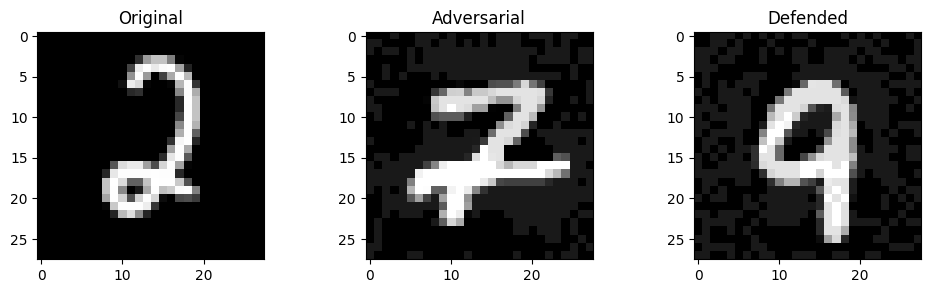

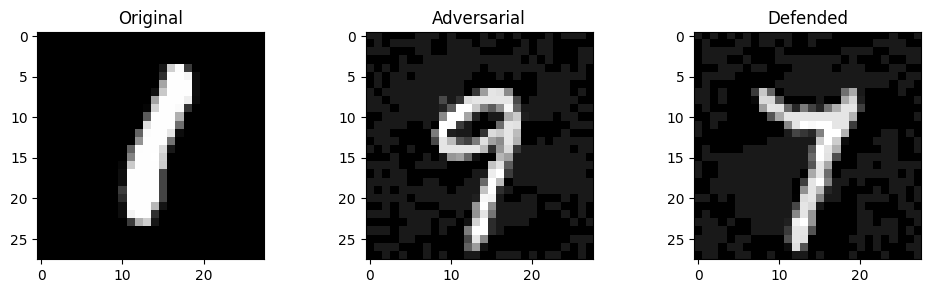

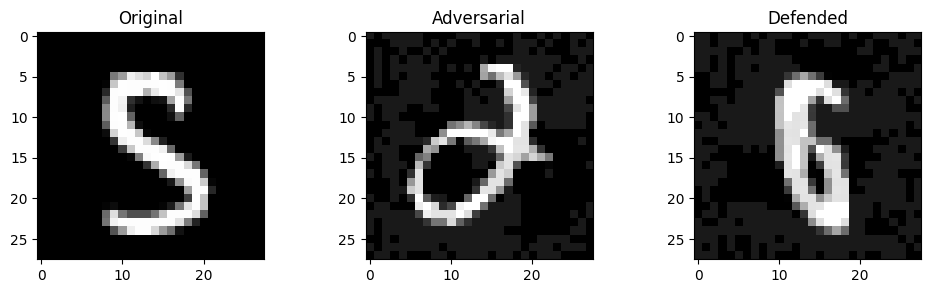

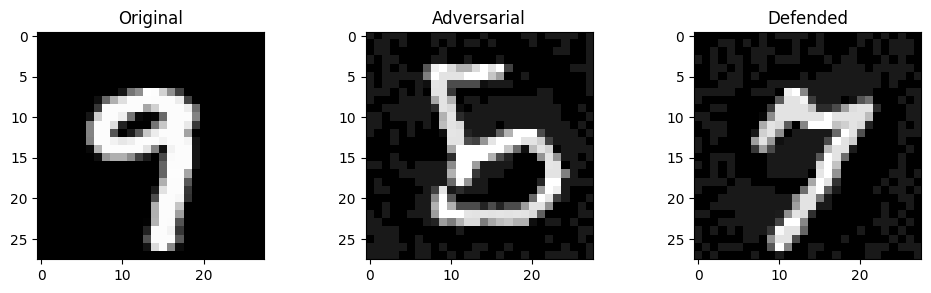

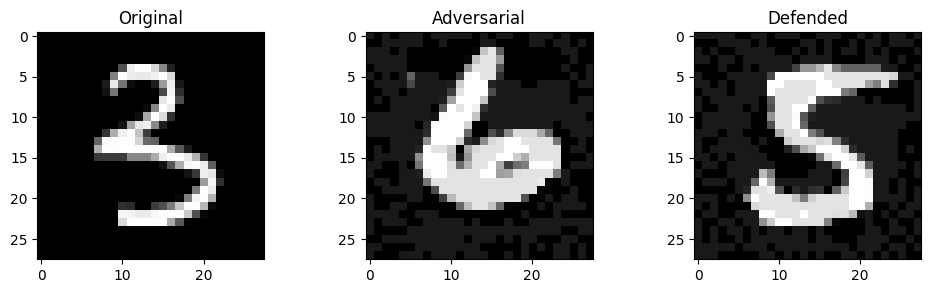

In [70]:
# Function to plot images
def plot_images(original, adversarial, defended):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    
    # Since the shape is (64, 28, 28), let's just visualize the first image
    original = original[0]  # Selecting the first image in the batch
    adversarial = adversarial[0]  # Selecting the first image in the batch
    defended = defended[0]  # Selecting the first image in the batch

    # Now plot them as grayscale images
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title('Original')
    ax[1].imshow(adversarial, cmap='gray')
    ax[1].set_title('Adversarial')
    ax[2].imshow(defended, cmap='gray')
    ax[2].set_title('Defended')
    
    plt.tight_layout()
    plt.show()

# Visualize first 5 images
for i in range(5):
    orig_img = clean_examples[i][2]
    adv_img = adv_examples[i][2]
    def_img = def_examples[i][2]
    
    plot_images(orig_img, adv_img, def_img)


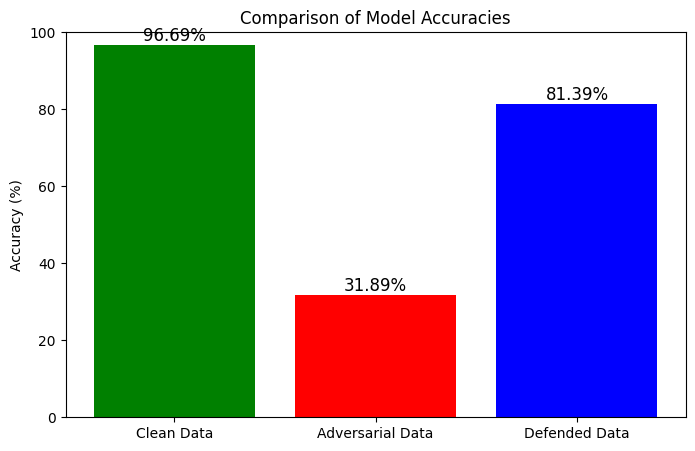

In [71]:
# Store the accuracies for clean, adversarial, and defended data
accuracies = [clean_acc * 100, adv_acc * 100, def_acc * 100]
labels = ['Clean Data', 'Adversarial Data', 'Defended Data']

# Function to plot comparison of accuracies
def plot_accuracy_comparison(accuracies, labels):
    plt.figure(figsize=(8, 5))
    plt.bar(labels, accuracies, color=['green', 'red', 'blue'])
    plt.ylim(0, 100)  # Set y-axis limits to 0-100% for accuracy
    plt.ylabel('Accuracy (%)')
    plt.title('Comparison of Model Accuracies')
    
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 1, f'{acc:.2f}%', ha='center', fontsize=12)

    plt.show()

# Plot the comparison chart
plot_accuracy_comparison(accuracies, labels)


In [79]:
def pgd_attack(model, data, target, epsilon, alpha, num_iter):
    # Clone data to create the initial perturbed data and ensure it's a leaf tensor
    perturbed_data = data.clone().detach().to(device)
    perturbed_data.requires_grad = True  # Set requires_grad for the leaf tensor

    for _ in range(num_iter):
        # Zero out previous gradients
        output = model(perturbed_data)
        loss = F.cross_entropy(output, target)

        model.zero_grad()  # Reset gradients
        loss.backward()  # Calculate gradients
        
        # Get the gradient of the perturbed data
        grad = perturbed_data.grad.data
        
        # Update the perturbed data using the sign of the gradient
        perturbed_data = perturbed_data + alpha * grad.sign()
        
        # Clamp the perturbation to ensure it's within the epsilon-ball
        perturbed_data = torch.clamp(perturbed_data, data - epsilon, data + epsilon)
        
        # Clamp to [0, 1] range to ensure valid pixel values
        perturbed_data = torch.clamp(perturbed_data, 0, 1)

        # Detach and re-attach requires_grad to keep perturbed_data a leaf tensor
        perturbed_data = perturbed_data.detach()
        perturbed_data.requires_grad = True

    return perturbed_data


In [80]:
# Evaluate with PGD Attack
def test_pgd(model, device, test_loader, epsilon=0.1, alpha=0.01, num_iter=40):
    correct = 0
    examples = []

    model.eval()  # Set the model to evaluation mode
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Get the initial prediction on clean data
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        # Perform the PGD attack
        perturbed_data = pgd_attack(model, data, target, epsilon, alpha, num_iter)

        # Re-classify the perturbed data
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]

        # Check if the prediction was correct
        correct += final_pred.eq(target.view_as(final_pred)).sum().item()

        # Save some examples for visualization
        if len(examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            examples.append((init_pred[0].item(), final_pred[0].item(), adv_ex))

    accuracy = correct / len(test_loader.dataset)
    return accuracy, examples


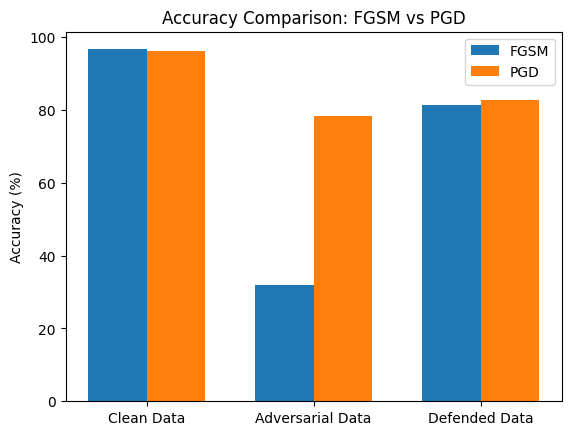

In [81]:
# Main Execution (with PGD)
# Evaluate on clean data
clean_acc_pgd, clean_examples_pgd = test(model, device, test_loader)

# Evaluate with PGD adversarial data
adv_acc_pgd, adv_examples_pgd = test_pgd(model, device, test_loader, epsilon=0.1, alpha=0.01, num_iter=40)

# Defended accuracy using adversarial training (for PGD)
for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    loss = F.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = pgd_attack(model, data, target, epsilon=0.1, alpha=0.01, num_iter=40)
    optimizer.zero_grad()
    output = model(perturbed_data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

# Evaluate defended accuracy for PGD
def_acc_pgd, def_examples_pgd = test_pgd(model, device, test_loader, epsilon=0.1, alpha=0.01, num_iter=40)

# Plot comparison chart between FGSM and PGD
labels = ['Clean Data', 'Adversarial Data', 'Defended Data']
fgsm_accuracies = [clean_acc * 100, adv_acc * 100, def_acc * 100]
pgd_accuracies = [clean_acc_pgd * 100, adv_acc_pgd * 100, def_acc_pgd * 100]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fgsm_accuracies, width, label='FGSM')
rects2 = ax.bar(x + width/2, pgd_accuracies, width, label='PGD')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison: FGSM vs PGD')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


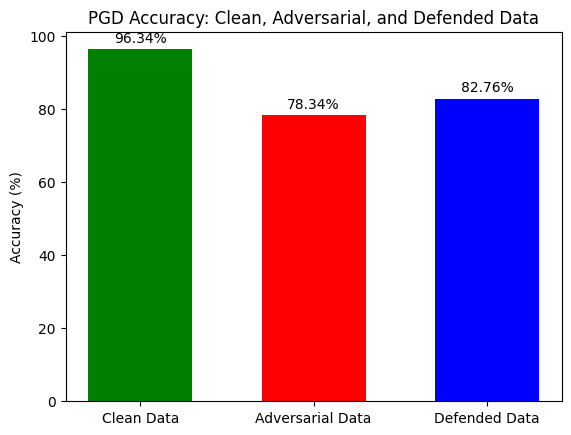

In [83]:
# Labels for the chart
labels = ['Clean Data', 'Adversarial Data', 'Defended Data']

# Accuracy values for PGD method
pgd_accuracies = [clean_acc_pgd * 100, adv_acc_pgd * 100, def_acc_pgd * 100]

# Colors: green for clean, red for adversarial, and blue for defended data
colors = ['green', 'red', 'blue']

# Plotting the chart
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, pgd_accuracies, width, color=colors)

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Accuracy (%)')
ax.set_title('PGD Accuracy: Clean, Adversarial, and Defended Data')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Adding the accuracy values on top of each bar
for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

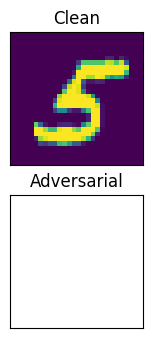

In [84]:
import matplotlib.pyplot as plt

# Function to plot images (clean, adversarial, defended) side by side
def plot_comparison(original, adversarial, defended, num_images=6):
    plt.figure(figsize=(12, 6))
    
    for i in range(num_images):
        # Display clean (original) image
        plt.subplot(3, num_images, i + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title("Clean")
        plt.imshow(original[i].cpu().permute(1, 2, 0))  # Adjust based on your data format

        # Display adversarial image
        plt.subplot(3, num_images, num_images + i + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title("Adversarial")
        plt.imshow(adversarial[i].cpu().permute(1, 2, 0))  # Adjust based on your data format

        # Display defended image
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title("Defended")
        plt.imshow(defended[i].cpu().permute(1, 2, 0))  # Adjust based on your data format
    
    plt.tight_layout()
    plt.show()

# Select a small batch of images (e.g., 6 images)
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images[:6].to(device), labels[:6].to(device)

# Generate adversarial examples using PGD
adv_images_pgd = pgd_attack(model, images, labels, epsilon=0.1, alpha=0.01, num_iter=40)

# Defended images (after adversarial training or defense)
def_images_pgd = model(images)  # This depends on your defense mechanism; replace with appropriate code

# Plot the comparison between clean, adversarial, and defended images for PGD
plot_comparison(images, adv_images_pgd, def_images_pgd)


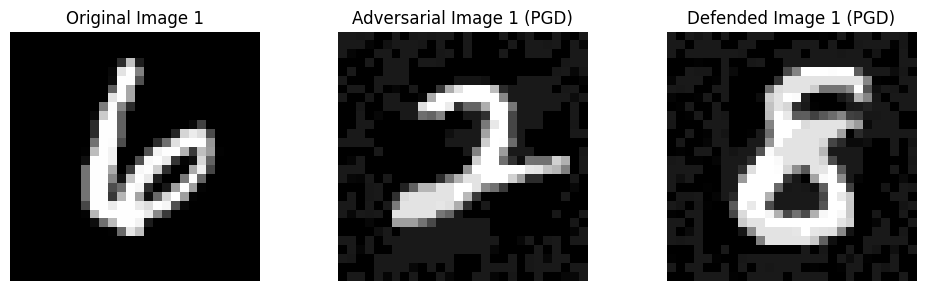

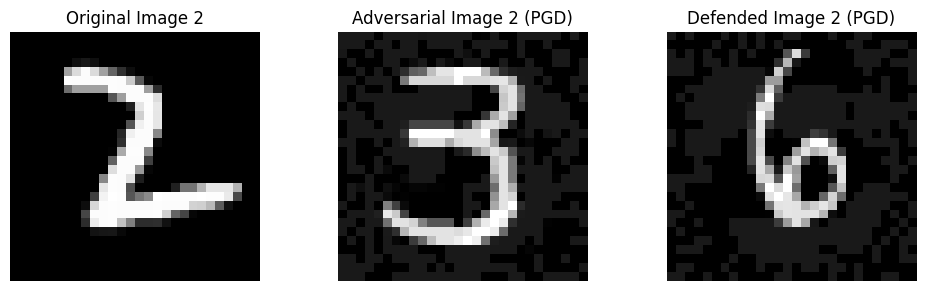

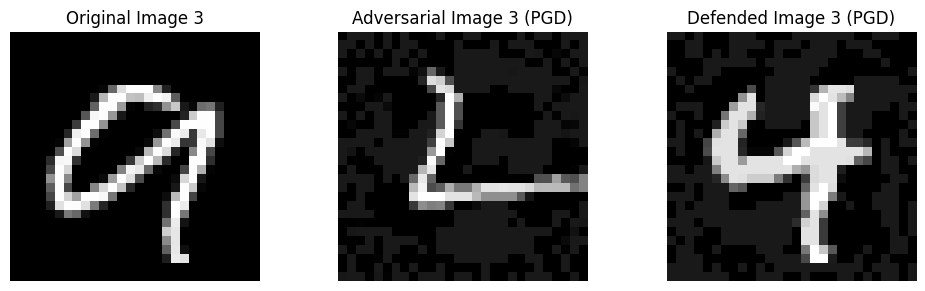

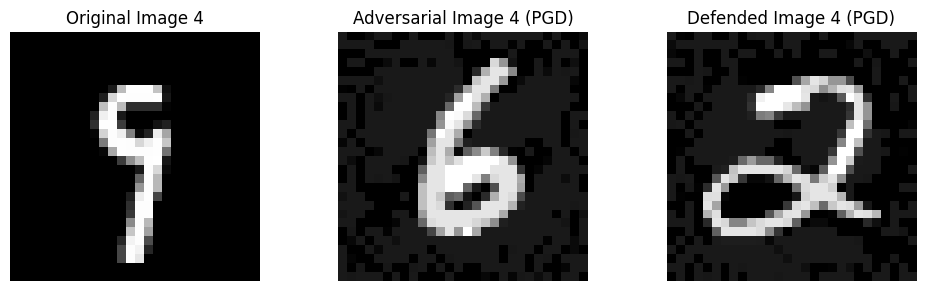

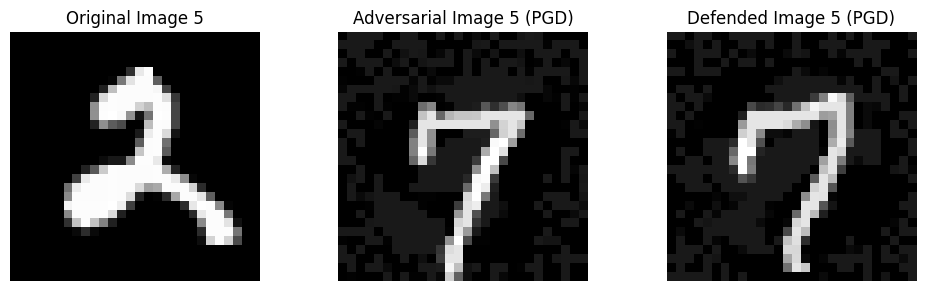

In [89]:
import matplotlib.pyplot as plt

# Function to plot images (clean, adversarial, defended) for PGD method
def plot_images_pgd(original, adversarial, defended, idx):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    
    # Adjust the dimensions by selecting the first image from each (e.g., [64, 28, 28] -> [28, 28])
    original = original[0].squeeze()  # Select the first image in the batch and squeeze it
    adversarial = adversarial[0].squeeze()
    defended = defended[0].squeeze()

    # Plot each image (ensure it's 2D for grayscale images)
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title(f'Original Image {idx+1}')
    ax[0].axis('off')

    ax[1].imshow(adversarial, cmap='gray')
    ax[1].set_title(f'Adversarial Image {idx+1} (PGD)')
    ax[1].axis('off')

    ax[2].imshow(defended, cmap='gray')
    ax[2].set_title(f'Defended Image {idx+1} (PGD)')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize first 5 images (loop through clean, adversarial, and defended examples)
for i in range(5):
    orig_img = clean_examples_pgd[i][2]  # PGD: Clean examples
    adv_img = adv_examples_pgd[i][2]     # PGD: Adversarial examples
    def_img = def_examples_pgd[i][2]     # PGD: Defended examples
    
    plot_images_pgd(orig_img, adv_img, def_img, i)
